In [1]:
## Loding libraries
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import arviz as az
import pickle

In [2]:
## Preprocecing ##
jh_dir = "../../COVID-19"
Confirmed = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df
confirmed = confirmed.cummax()
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.cummax()
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.cummax()

In [3]:
## Definitions ##

In [4]:
### dates ###
epoch = pd.to_datetime('2020-01-22')
last = pd.to_datetime('2020-05-18')
upto = last-pd.Timedelta(days=2)
index= pd.date_range(start=epoch, end=upto)

In [19]:
### Fitting a model ###
def fit_and_infer(sm=None, data=None, country=None, population=None, detection_rate=1,
                  b_sigma_0=1, inits='random', iteration=10000, start=epoch, last=last):
    if data is None:
        C0 = confirmed.loc[start:last, country].values
        D0 = death.loc[start:last, country].values
        P = population
        data = {'T': C0.shape[0], 'T0': 0, 'P': P, 'C0': C0, 'D0':D0, 
                'q0':detection_rate, 'b_sigma_0':b_sigma_0}
    fit = sm.sampling(data=data, iter=iteration, init=inits)
    print(fit)
    return az.from_pystan(fit, log_likelihood='log_lik')

In [6]:
### Extract data ###
def extract_var(var_name=None, data=None, start=epoch):
    d = data.posterior[var_name].stack(sample=('chain', 'draw')).values
    return pd.DataFrame(d, index=pd.date_range(start, end=start+pd.Timedelta(days=len(d)-1)))

In [7]:
### Drawing ###
def draw(data, index=index, name=None, line=None, label_name=None, value_name='value'):
    df = pd.DataFrame()
    dfs = []
    for label, samples in data.items():
        samples['Date'] = samples.index
        melted=pd.melt(samples, id_vars=['Date'])
        if label_name is not None:
            melted[label_name]=label
        dfs.append(melted)
    df = pd.concat(dfs)
    df = df.rename(columns={'value':value_name})
    if label_name is not None:
        g=sns.relplot(kind="line", data=df, aspect=2, ci='sd', x='Date', y=value_name, hue=label_name)
    else:
        g=sns.relplot(kind="line", data=df, aspect=2, ci='sd', x='Date', y=value_name)
    ax = g.axes[0][0]
    if line is not None:
        ax.axhline(y = line, color='grey', linestyle='--', linewidth=2, alpha=.7)
    g.savefig("{}.pdf".format(name))
    plt.show()

In [23]:
## Compile models ##
sm = pystan.StanModel(file="model.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d846fe278209b62bff35f8ebed99a7c0 NOW.


In [12]:
## Model Validation ##

In [24]:
#### Constant parameters ####
from scipy.stats import poisson
def simulate(b, q, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q)]
    R_obs = [0]
    D_obs = [0]
    for t in index:
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        I = I + NI - NR - ND
        C = C + NI
        R = R + NR
        D = ND
        C_obs.append(int(C_obs[-1]+poisson.rvs(q*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 'T':len(C_obs), 'T0':0, 'P':P, 'b_sigma_0':0.1, 'q0':q}

data = simulate(0.07, 0.2, 100, 0.04, 0.001, 1200_0000, index)

infered = fit_and_infer(sm=sm, data=data)


Inference for Stan model: anon_model_d846fe278209b62bff35f8ebed99a7c0.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      42.94    0.82  23.08  15.61  27.75  37.98  51.79  99.91    798   1.01
b_sigma      2.7e-3  6.3e-5 1.2e-3 9.9e-4 1.8e-3 2.5e-3 3.3e-3 5.7e-3    374   1.01
b[1]           0.07  7.4e-4   0.02   0.02   0.06   0.07   0.09   0.12   1021    1.0
b[2]           0.07  6.9e-4   0.02   0.03   0.06   0.07   0.09   0.12   1033    1.0
b[3]           0.08  6.7e-4   0.02   0.03   0.06   0.07   0.09   0.12   1026    1.0
b[4]           0.08  6.6e-4   0.02   0.04   0.06   0.07   0.09   0.12   1010    1.0
b[5]           0.08  6.3e-4   0.02   0.04   0.06   0.07   0.09   0.12   1031    1.0
b[6]           0.08  6.3e-4   0.02   0.04   0.06   0.08   0.09   0.12   1011    1.0
b[7]           0.08  6.2e-4   0.02   0.04   0.06   0.

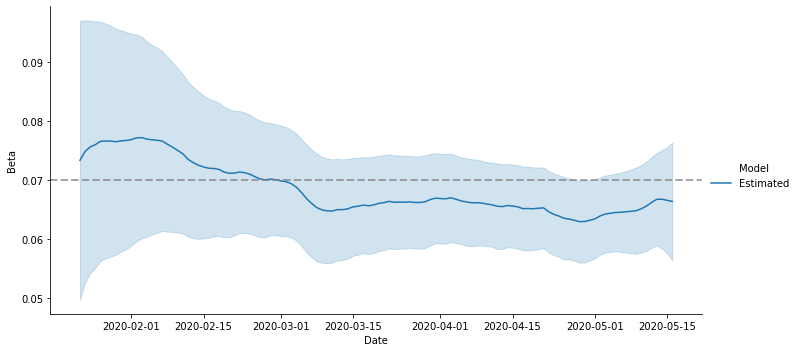

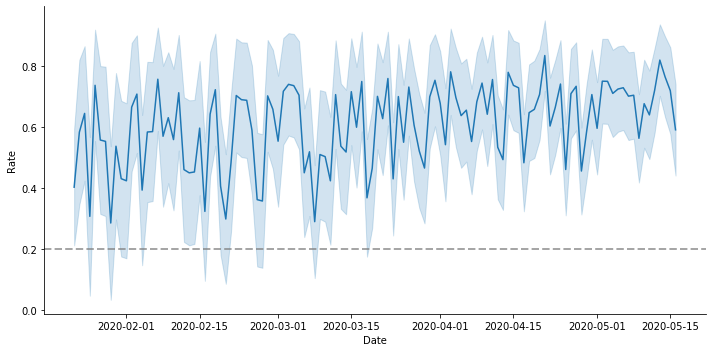

In [25]:
beta = extract_var(var_name='b', data=infered)
q = extract_var(var_name='q', data=infered)
draw({'Estimated':beta}, name='const_beta', line=0.07, 
     label_name='Model', value_name='Beta')
draw({'Estimated':q}, line=0.2, name='const_q', label_name=None, value_name='Rate')

In [28]:
#### Step-like detection rate ####
from scipy.stats import poisson
def simulate(b, q1, q2, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q1)]
    D_obs = [0]
    R_obs = [0]
    q=[]
    for t in index:
        if t < pd.to_datetime('2020-04-01'):
            q.append(q1)
        else:
            q.append(q2)
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        I = I + NI - NR - ND
        C = C+NI
        C_obs.append(int(C_obs[-1]+poisson.rvs(q[-1]*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 
            'T':len(C_obs), 'T0':0, 'P':P, 'b_sigma_0':0.1, 'q0':q1}, np.array(q)

data, q_true = simulate(0.07, 1, 0.5, 100, 0.04, 0.001, 1200_0000, index)

infered = fit_and_infer(sm=sm, data=data)


Inference for Stan model: anon_model_d846fe278209b62bff35f8ebed99a7c0.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     235.79     6.0 127.26 104.14 147.79 198.21 281.97 583.49    449   1.01
b_sigma      3.1e-3  4.2e-5 1.1e-3 1.4e-3 2.4e-3 3.0e-3 3.8e-3 5.6e-3    636    1.0
b[1]           0.04  6.7e-4   0.02 4.1e-3   0.03   0.04   0.06   0.09   1235    1.0
b[2]           0.05  7.3e-4   0.02   0.02   0.04   0.05   0.07   0.09    779   1.01
b[3]           0.05  7.3e-4   0.02   0.02   0.04   0.05   0.07   0.09    756   1.01
b[4]           0.06  7.4e-4   0.02   0.02   0.04   0.06   0.07   0.09    723   1.01
b[5]           0.06  7.4e-4   0.02   0.02   0.04   0.06   0.07   0.09    704   1.01
b[6]           0.06  7.4e-4   0.02   0.02   0.04   0.06   0.07    0.1    707   1.01
b[7]           0.06  7.2e-4   0.02   0.02   0.05   0.

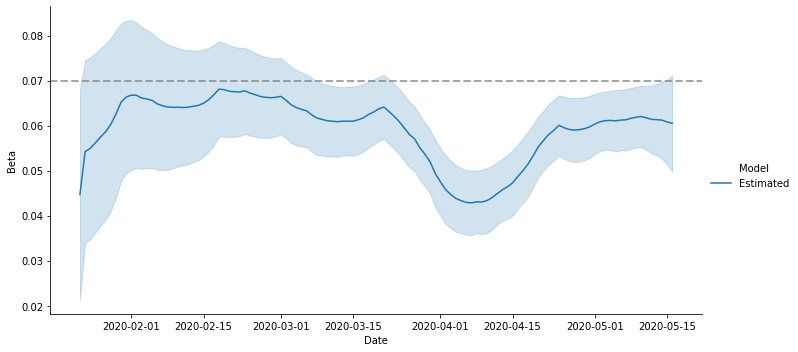

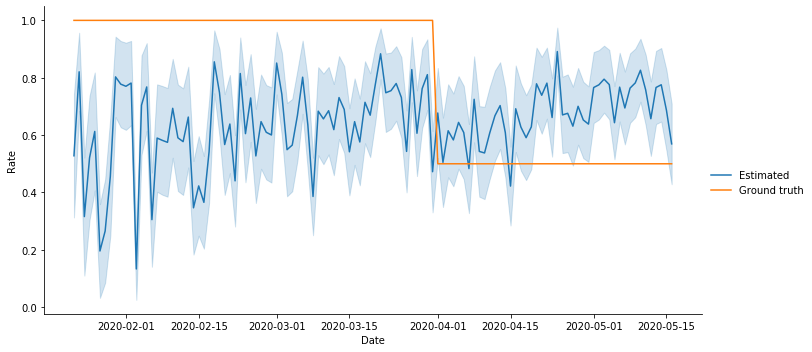

In [29]:
beta = extract_var(var_name='b', data=infered)
q = extract_var(var_name='q', data=infered)
                     
draw({'Estimated':beta}, name='step_beta', 
     label_name='Model', value_name='Beta', line=0.07)

q_true = pd.DataFrame(q_true, index)
draw({'Estimated':q, 'Ground truth':q_true}, name='step_q', value_name='Rate', label_name='')

In [30]:
#### Changing beta ####
from scipy.stats import poisson
def simulate(b0, b1, q0, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q0)]
    q = [q0]
    D_obs = [0]
    R_obs = [0]
    b = [b0]
    for t in index:
        NI = poisson.rvs(b[-1]*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        C = C+NI
        I = I + NI - NR - ND
        C_obs.append(int(C_obs[-1]+poisson.rvs(q[-1]*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
        q.append(q0 + 0.05*np.random.randn(1)[0])
        b.append(b[-1] - b1)
 
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 
            'T':len(C_obs), 'T0':0, 'P':P, 'b_sigma_0':1, 'q0':q0}, np.array(q), np.array(b)
data, q_true, b_true = simulate(0.16, 0.001, 0.5, 100, 0.04, 0.001, 1200_0000, index)

infered = fit_and_infer(sm=sm, data=data)


Inference for Stan model: anon_model_d846fe278209b62bff35f8ebed99a7c0.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     120.79    0.97   42.7  63.13  90.49 112.86 142.02 224.66   1953    1.0
b_sigma      3.1e-3  3.1e-5 9.1e-4 1.7e-3 2.5e-3 3.0e-3 3.7e-3 5.3e-3    876    1.0
b[1]           0.13  4.4e-4   0.02   0.08   0.11   0.13   0.14   0.18   2871    1.0
b[2]           0.13  4.3e-4   0.02   0.08   0.12   0.13   0.14   0.17   2797    1.0
b[3]           0.13  4.3e-4   0.02   0.09   0.12   0.13   0.14   0.17   2693    1.0
b[4]           0.13  4.2e-4   0.02   0.09   0.12   0.13   0.15   0.17   2590    1.0
b[5]           0.13  4.1e-4   0.02   0.09   0.12   0.13   0.15   0.17   2525    1.0
b[6]           0.13  4.0e-4   0.02   0.09   0.12   0.13   0.15   0.17   2455    1.0
b[7]           0.13  3.9e-4   0.02   0.09   0.12   0.

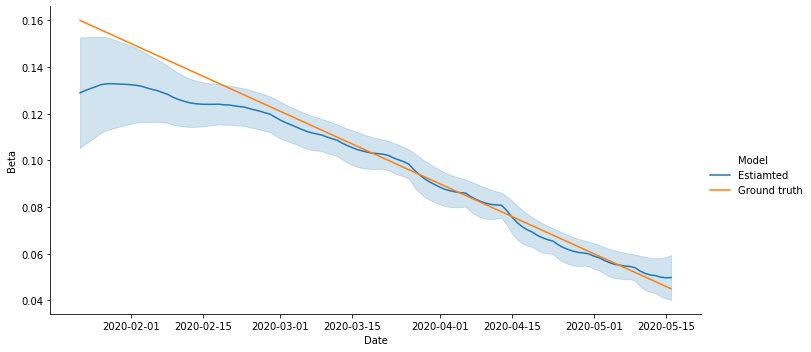

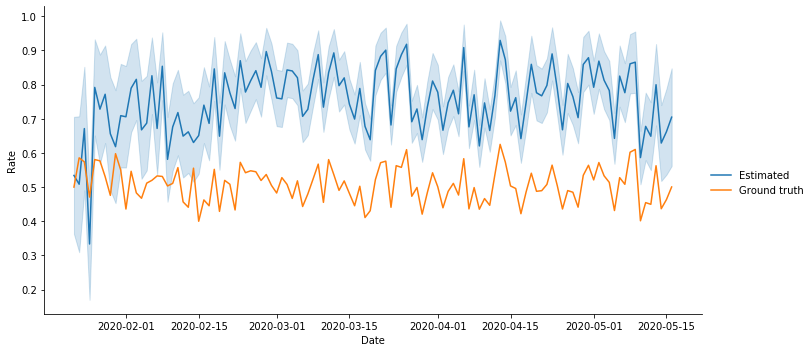

In [32]:
beta = extract_var('b', infered)
q = extract_var('q', infered)
b = extract_var('b', infered)
                  
b_true = pd.DataFrame(b_true[:-1], index)
draw({'Estiamted':beta, 'Ground truth':b_true}, 
     name='trend_beta', label_name='Model', value_name='Beta')

q_true = pd.DataFrame(q_true[:-1], index)
draw({'Estimated':q, 'Ground truth':q_true}, name='trend_q', value_name='Rate', label_name='')

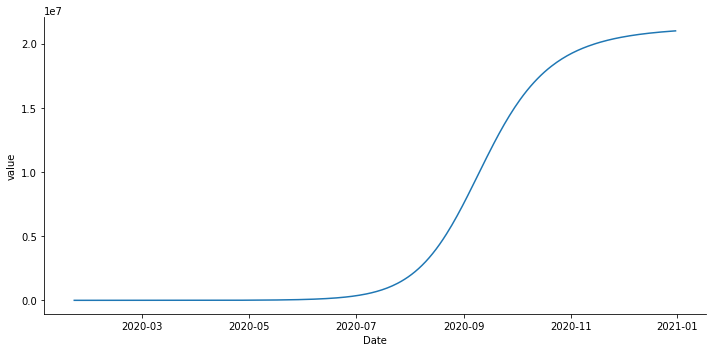

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_d846fe278209b62bff35f8ebed99a7c0.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf        1.9     1.1   1.56   0.24   0.45    1.6    3.4   4.18      2 243.84
b_sigma         0.2    0.07    0.1   0.03   0.11   0.25   0.29   0.34      2   4.54
b[1]           2.35     0.9   1.28   0.46   1.11   2.58   3.58    3.6      2  46.72
b[2]           0.46    0.16   0.23   0.22   0.25   0.44   0.69   0.76      2 116.54
b[3]           1.74    1.18   1.67   0.18   0.59   1.12   2.94   4.63      2  68.07
b[4]           1.32    0.95   1.34    0.2   0.31   0.77   2.42   3.61      2 204.45
b[5]           0.92    0.55   0.77   0.29   0.41   0.56   1.51   2.25      2 190.51
b[6]           1.13    1.15   1.63   0.16   0.19    0.2   2.24    4.0      2 181.72
b[7]           0.55    0.28    0.4   0.24   0.26   0.

In [33]:
# #### Saturate ####
# from scipy.stats import poisson
# def simulate(b, q, init_inf, a, d, P, index):
#     C = init_inf
#     I = init_inf
#     R = 0
#     D = 0
#     C_obs = [poisson.rvs(init_inf*q)]
#     R_obs = [0]
#     D_obs = [0]
#     for t in index:
#         NI = poisson.rvs(b*I*(1-C/P))
#         NR = poisson.rvs(a*I)
#         ND = poisson.rvs(d*I)
#         I = I + NI - NR - ND
#         C = C + NI
#         R = R + NR
#         D = ND
#         C_obs.append(int(C_obs[-1]+poisson.rvs(q*NI)))
#         D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
#         R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
#     return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 'T':len(C_obs), 'T0':0, 'P':P, 'b_sigma_0':1, 'q0':q}

# index=pd.date_range(start=epoch, end=pd.to_datetime('2020-12-31'))
# data = simulate(0.10, 0.2, 100, 0.04, 0.001, 12000_0000,index)
# C0 = pd.DataFrame(data['C0'][:-1], index)
# draw({'Cumulative':C0})

# infered = fit_and_infer(sm=sm, data=data)

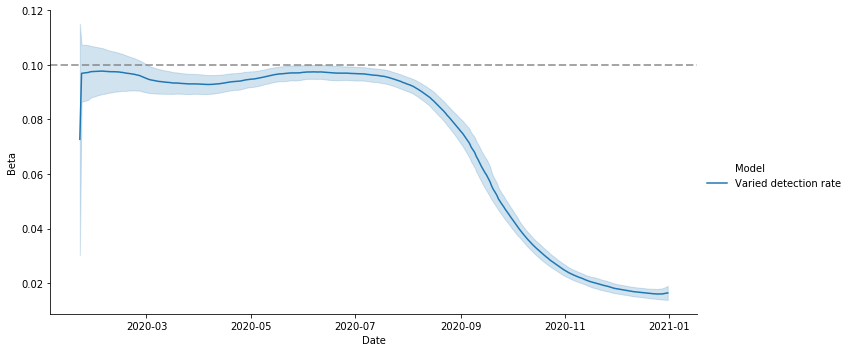

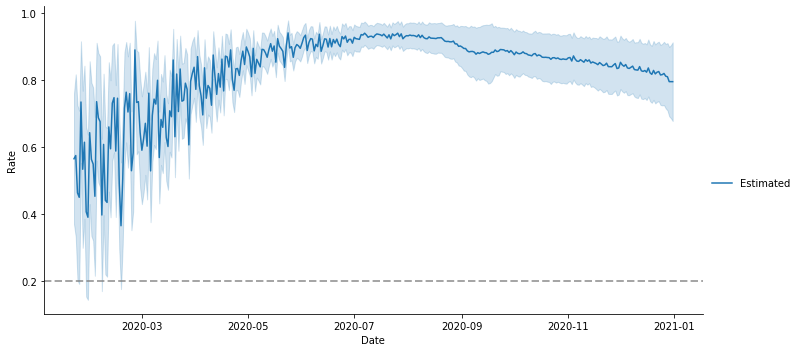

In [17]:
# beta_const_q = extract_var('b', infered_const_q)
# beta = extract_var('b', infered_every)
# q = extract_var('q', infered_every)
# draw({'Varied detection rate':beta}, name='saturate_beta', line=0.10, 
#      label_name='Model', value_name='Beta')
# draw({'Estimated':q}, line=0.2, name='saturate_q', value_name='Rate', label_name='')

In [35]:
## Analysis ##
iteration = 10000

In [36]:
### Japanese case ###
P = 126_500_000
infer = fit_and_infer(sm=sm, country='Japan', population=P, iteration=iteration)

Inference for Stan model: anon_model_d846fe278209b62bff35f8ebed99a7c0.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       42.6    0.98  29.93   7.37  21.81  35.71  55.23 119.82    933    1.0
b_sigma      8.8e-3  7.9e-5 2.4e-3 5.0e-3 7.1e-3 8.6e-3   0.01   0.01    902   1.01
b[1]           0.03  8.1e-4   0.04 1.6e-3 9.1e-3   0.02   0.04   0.14   2077    1.0
b[2]           0.05  9.5e-4   0.04 4.5e-3   0.02   0.03   0.06   0.15   1723    1.0
b[3]           0.06  1.0e-3   0.04 7.8e-3   0.03   0.04   0.08   0.16   1598    1.0
b[4]           0.07  1.0e-3   0.04   0.01   0.04   0.06   0.09   0.16   1541    1.0
b[5]           0.07  1.0e-3   0.04   0.02   0.04   0.06   0.09   0.16   1481    1.0
b[6]           0.08  9.9e-4   0.04   0.02   0.05   0.07    0.1   0.17   1471    1.0
b[7]           0.08  9.9e-4   0.04   0.02   0.05   0.

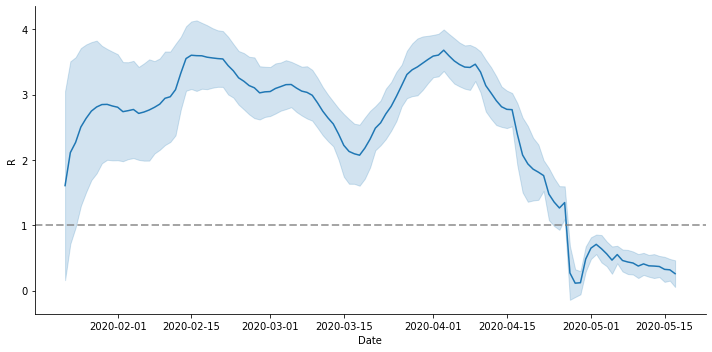

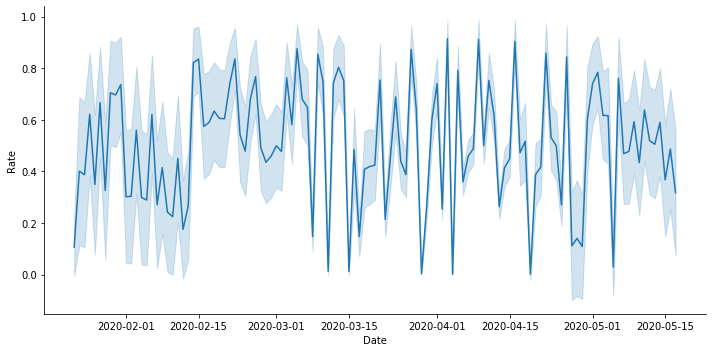

In [37]:
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
R_J = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_J}, line=1, name='R_Japan', value_name='R')
draw({'Detection rate':q}, name='q_Japan', value_name='Rate')

In [38]:
#### Sensiticity Analysis ####
infer_s = fit_and_infer(sm=sm, country='Japan', population=P, iteration=iteration, b_sigma_0=0.1)

Inference for Stan model: anon_model_d846fe278209b62bff35f8ebed99a7c0.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      43.95    1.04  30.83   6.81  22.59  37.14  57.42 119.94    875    1.0
b_sigma      8.9e-3  7.5e-5 2.3e-3 5.2e-3 7.3e-3 8.7e-3   0.01   0.01    963    1.0
b[1]           0.03  9.7e-4   0.04 1.6e-3 9.3e-3   0.02   0.04   0.14   1461    1.0
b[2]           0.04  1.1e-3   0.04 4.4e-3   0.02   0.03   0.06   0.15   1360    1.0
b[3]           0.05  1.1e-3   0.04 8.2e-3   0.03   0.04   0.07   0.16   1219    1.0
b[4]           0.06  1.1e-3   0.04   0.01   0.04   0.06   0.08   0.16   1278    1.0
b[5]           0.07  1.1e-3   0.04   0.02   0.04   0.06   0.09   0.17   1209    1.0
b[6]           0.08  1.1e-3   0.04   0.02   0.05   0.07    0.1   0.17   1159    1.0
b[7]           0.08  1.1e-3   0.04   0.02   0.05   0.

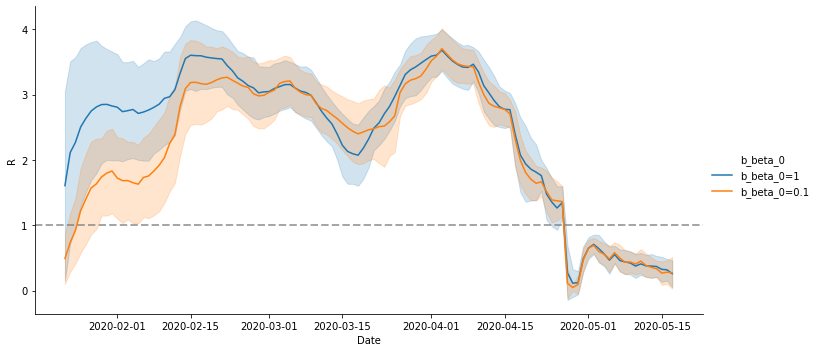

In [39]:
infer = infer_s
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
R_JS = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)
draw({'b_beta_0=1':R_J, 'b_beta_0=0.1':R_JS}, line=1, name='Sensitivity', 
     value_name='R', label_name='b_beta_0')

In [40]:
### China ###
P = 1_393_000_000
country='China'
infer = fit_and_infer(sm=sm, country=country, population=P, iteration=iteration)

Inference for Stan model: anon_model_d846fe278209b62bff35f8ebed99a7c0.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       6.49    0.94   1.33    4.3   5.33   6.94   7.56    7.8      2 374.85
b_sigma        1.28    0.75   1.07   0.19   0.22   1.18   2.35   2.55      2 1639.8
b[1]           1.94    1.77    2.5   0.34   0.42   0.57   3.72   6.27      2 2456.5
b[2]           2.68    1.32   1.87   0.88   0.99   2.16   4.47   5.51      2 1308.2
b[3]           3.15    1.35   1.91   0.38   1.58   3.24    4.7   5.77      2 1137.8
b[4]           1.61    0.65   0.92   0.87   0.97    1.2   2.33   3.19      2 1075.5
b[5]           1.46    1.49    2.1   0.14   0.14   0.31   3.01    5.1      2 2917.0
b[6]           2.52    1.61   2.28   0.18   0.24    2.4   4.82   5.08      2 1247.4
b[7]           1.59    0.94   1.32   0.29   0.63   1.

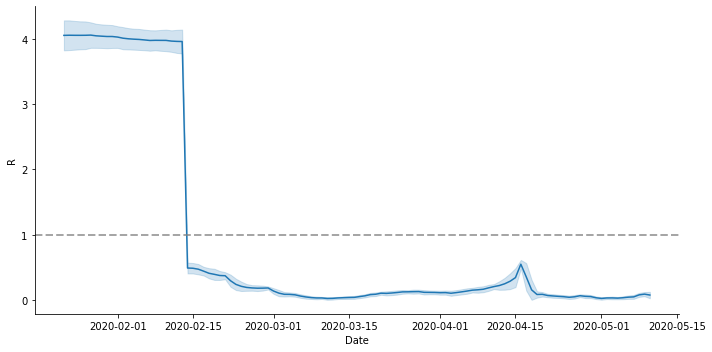

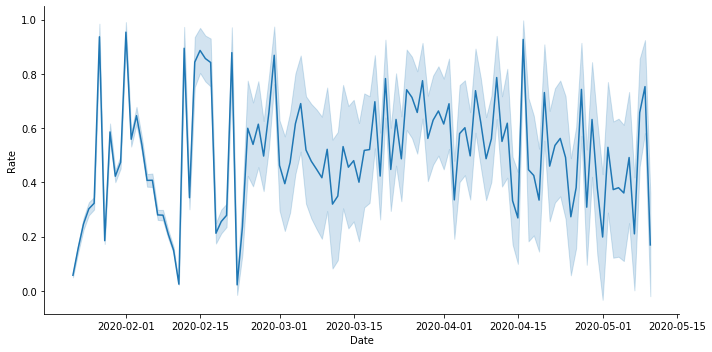

In [24]:
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
R_C = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_C}, line=1, name='R_China', value_name='R')
draw({'Detection rate':q}, name='q_China', value_name='Rate')

In [41]:
### US ###
P = 327_200_000
country='US'
infer = fit_and_infer(sm=sm, country=country, population=P, iteration=iteration)

Inference for Stan model: anon_model_d846fe278209b62bff35f8ebed99a7c0.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      33.31    0.52  19.93   6.39  18.94  29.55  43.46  81.98   1491    1.0
b_sigma        0.01  6.7e-5 2.6e-3 7.0e-3 9.6e-3   0.01   0.01   0.02   1472    1.0
b[1]           0.03  5.1e-4   0.03 2.2e-3   0.01   0.02   0.04   0.12   3674    1.0
b[2]           0.05  6.2e-4   0.03 7.5e-3   0.02   0.04   0.06   0.13   2840    1.0
b[3]           0.05  6.7e-4   0.03   0.01   0.03   0.05   0.07   0.14   2490    1.0
b[4]           0.06  7.0e-4   0.03   0.02   0.04   0.05   0.08   0.15   2295    1.0
b[5]           0.06  7.2e-4   0.03   0.01   0.04   0.05   0.08   0.14   2146    1.0
b[6]           0.06  7.4e-4   0.03   0.01   0.04   0.06   0.08   0.14   2065    1.0
b[7]           0.06  7.5e-4   0.03   0.01   0.04   0.

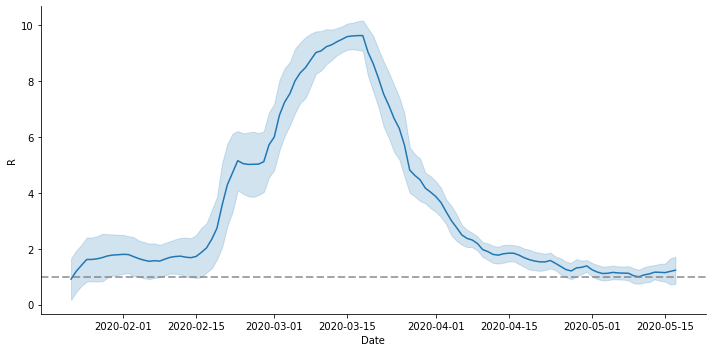

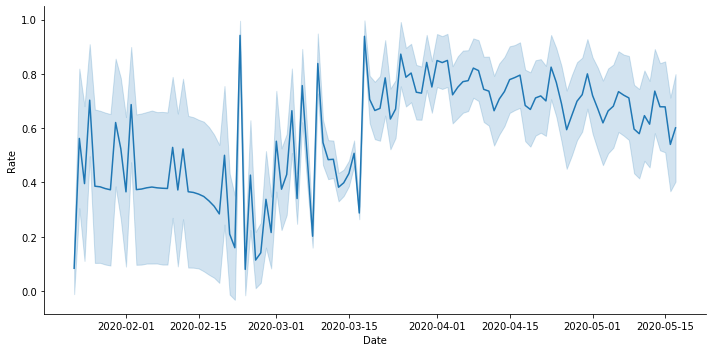

In [42]:
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
R_US = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_US}, line=1, name='R_US', value_name='R')
draw({'Detection rate':q}, name='q_US', value_name='Rate')

In [43]:
### Italy ###
P = 60_360_000
country='Italy'
start=pd.to_datetime('2020-02-01')
infer = fit_and_infer(sm=sm, country=country, population=P, start=start, iteration=iteration)

Inference for Stan model: anon_model_d846fe278209b62bff35f8ebed99a7c0.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     151.95   44.83 105.42  13.34   75.2 129.36 202.77 421.51      6   1.31
b_sigma      5.1e-3  3.1e-4 1.8e-3 2.3e-3 3.8e-3 4.9e-3 6.1e-3 9.1e-3     31   1.09
b[1]           0.01  1.7e-3   0.02 4.9e-4 3.1e-3 6.0e-3   0.01   0.04    121   1.04
b[2]           0.01  2.6e-3   0.02 1.2e-3 5.2e-3 9.0e-3   0.02   0.05     71   1.07
b[3]           0.02  4.0e-3   0.03 1.6e-3 6.2e-3   0.01   0.02   0.07     49    1.1
b[4]           0.02  4.2e-3   0.03 1.9e-3 7.2e-3   0.01   0.02   0.07     45    1.1
b[5]           0.02  4.7e-3   0.03 2.3e-3 8.1e-3   0.01   0.02   0.07     44   1.11
b[6]           0.02  6.1e-3   0.04 3.1e-3 9.1e-3   0.01   0.02   0.09     38   1.13
b[7]           0.02  6.3e-3   0.04 2.6e-3 8.9e-3   0.

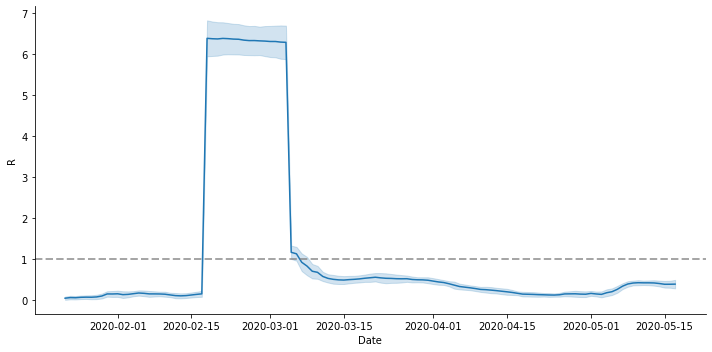

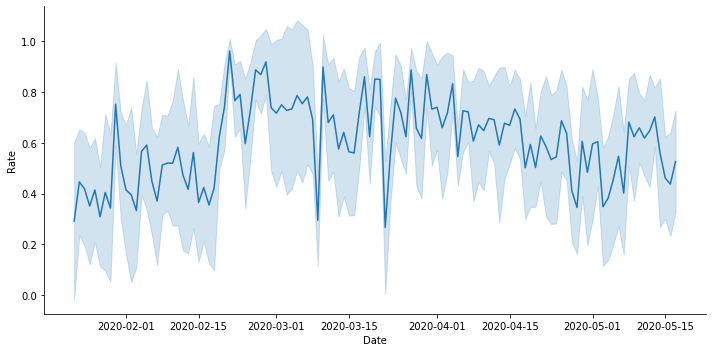

In [47]:
beta = extract_var(var_name='b', data=infer, start=start)
q = extract_var(var_name='q', data=infer, start=start)
C = extract_var(var_name='C', data=infer, start=start)
C = C[:-1]
R_I = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_I}, line=1, name='R_Italy', value_name='R')
draw({'Detection rate':q}, name='q_Italy', value_name='Rate')

In [45]:
### Korea ###
P = 51_640_000
country='Korea, South'
start=pd.to_datetime('2020-01-22')
infer = fit_and_infer(sm=sm, country=country, population=P, start=start, iteration=iteration)

Inference for Stan model: anon_model_d846fe278209b62bff35f8ebed99a7c0.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     605.89  475.42 739.14   1.05   1.69   42.8 1094.6 2320.6      2   2.45
b_sigma        0.47    0.47   0.67 7.8e-4 1.6e-3   0.05   1.12   1.63      2  18.33
b[1]            0.2    0.14    0.2 2.7e-4 1.7e-3   0.19    0.4   0.42      2   26.1
b[2]           0.19    0.14   0.22 5.9e-4 2.3e-3   0.15   0.26    0.7      2   3.71
b[3]           0.18    0.14    0.2 5.4e-4 2.5e-3    0.1   0.42   0.49      2  16.24
b[4]           0.21    0.19   0.27 7.7e-4 3.0e-3   0.12   0.28   0.82      2   4.55
b[5]           1.15    1.06    1.5 8.2e-4 3.2e-3   0.27   2.53   3.79      2  20.66
b[6]            0.3    0.22   0.33 6.8e-4 3.2e-3   0.21   0.44   1.02      2   5.85
b[7]           0.51    0.38   0.54 7.4e-4 3.6e-3   0.

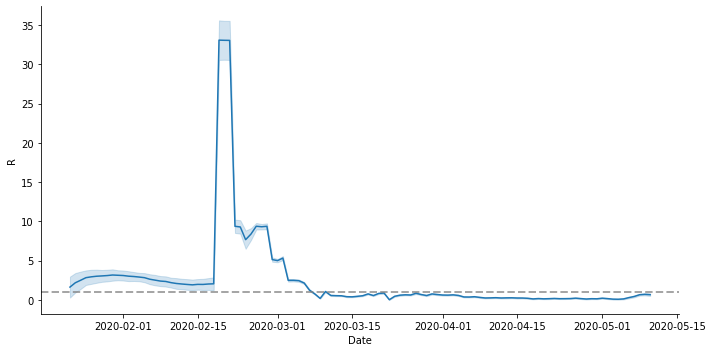

In [30]:
beta = extract_var(var_name='b', data=infer_const_q)
C = extract_var(var_name='C', data=infer_const_q)
C = C[:-1]
#d = extract_var(var_name='d', data=infer_const_q)
#print('{}, {}, {}'.format(beta.values.shape, d.values.shape, C.values.shape))
R_K = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_K}, line=1, name='R_Korea', value_name='R')

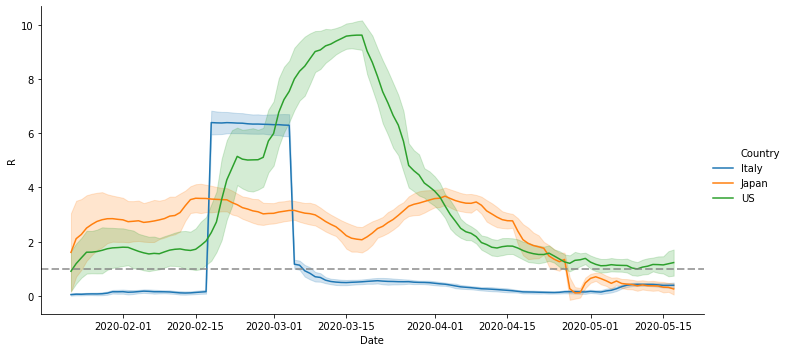

In [48]:
draw({'Italy':R_I, 'Japan':R_J, 'US':R_US}, line=1, name='R_multi', value_name='R', label_name='Country')

In [49]:
### Sweden ###
P = 10_230_000
country='Sweden'
start=pd.to_datetime('2020-02-01')
infer = fit_and_infer(sm=sm, country=country, population=P, start=start, iteration=iteration)

Inference for Stan model: anon_model_d846fe278209b62bff35f8ebed99a7c0.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      35.13    0.84  23.44   4.81  18.75  30.62  46.17  91.96    788    1.0
b_sigma      8.7e-3  8.0e-5 2.6e-3 4.5e-3 6.9e-3 8.5e-3   0.01   0.01   1057    1.0
b[1]           0.02  6.0e-4   0.02 1.4e-3 7.5e-3   0.01   0.03   0.09   1725    1.0
b[2]           0.03  7.2e-4   0.03 3.5e-3   0.01   0.02   0.04   0.11   1416    1.0
b[3]           0.04  8.2e-4   0.03 5.0e-3   0.02   0.03   0.04   0.11   1230    1.0
b[4]           0.04  8.9e-4   0.03 6.1e-3   0.02   0.03   0.05   0.12   1128    1.0
b[5]           0.04  9.6e-4   0.03 6.8e-3   0.02   0.04   0.05   0.13   1027    1.0
b[6]           0.05  1.0e-3   0.03 7.4e-3   0.02   0.04   0.06   0.13   1000    1.0
b[7]           0.05  1.1e-3   0.03 8.3e-3   0.03   0.

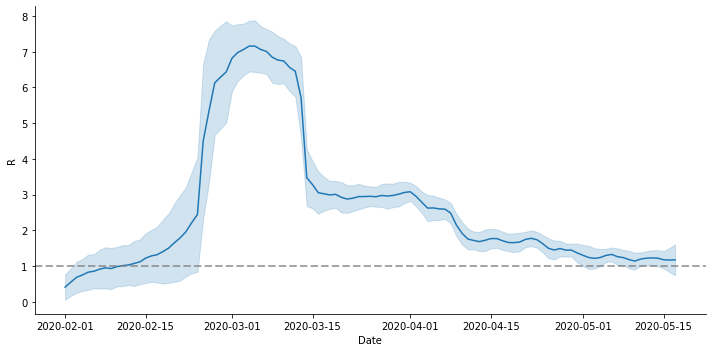

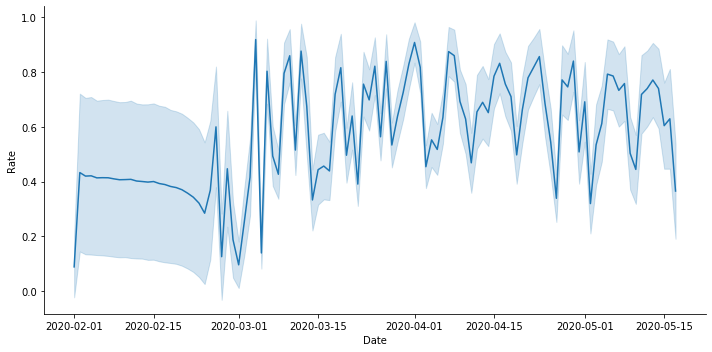

In [50]:
beta = extract_var(var_name='b', data=infer, start=start)
q = extract_var(var_name='q', data=infer, start=start)
C = extract_var(var_name='C', data=infer, start=start)
C = C[:-1]
R_S = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_S}, line=1, name='R_Sweden', value_name='R')
draw({'Detection rate':q}, name='q_Sweden', value_name='Rate')

In [51]:
### Denmark ###
P = 5_806_000
country='Denmark'
start=pd.to_datetime('2020-03-01')
infer = fit_and_infer(sm=sm, country=country, population=P, start=start, iteration=iteration)

Inference for Stan model: anon_model_d846fe278209b62bff35f8ebed99a7c0.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      7.14    0.34   7.13   1.83   3.63   5.31   8.12  24.09    442   1.01
b_sigma     6.4e-3  6.4e-5 1.8e-3 3.6e-3 5.1e-3 6.2e-3 7.5e-3   0.01    802   1.01
b[1]          0.65    0.01   0.14   0.34   0.58   0.66   0.73   0.89    167   1.02
b[2]          0.66  5.9e-3   0.11   0.43   0.59   0.66   0.73   0.89    374   1.01
b[3]          0.66  5.9e-3   0.11   0.43   0.59   0.66   0.73   0.89    370   1.01
b[4]          0.66  5.9e-3   0.11   0.43   0.59   0.66   0.73   0.89    364   1.01
b[5]          0.66  5.9e-3   0.11   0.44   0.59   0.66   0.73   0.89    357   1.01
b[6]          0.66  5.9e-3   0.11   0.44   0.59   0.66   0.73   0.89    354   1.01
b[7]          0.66  5.9e-3   0.11   0.44   0.59   0.66   0.73 

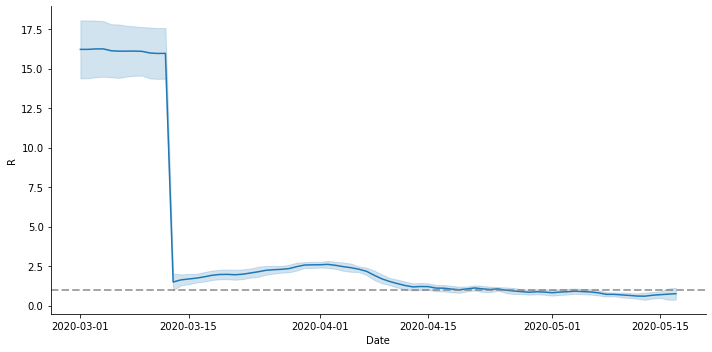

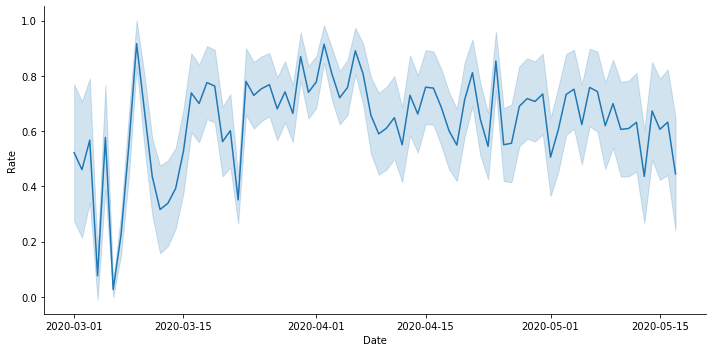

In [52]:
beta = extract_var(var_name='b', data=infer, start=start)
q = extract_var(var_name='q', data=infer, start=start)
C = extract_var(var_name='C', data=infer, start=start)
C = C[:-1]
R_D = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_D}, line=1, name='R_Denmark', value_name='R')
draw({'Detection rate':q}, name='q_Denmark', value_name='Rate')

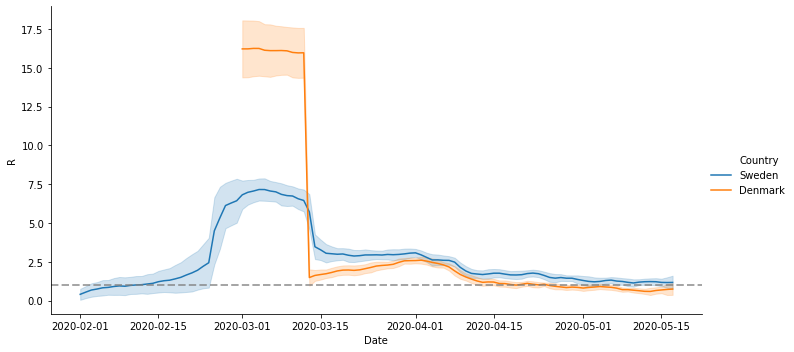

In [53]:
draw({'Sweden':R_S, 'Denmark':R_D,}, line=1, name='R_Nordic', value_name='R', label_name='Country')